<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap21/21_2_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 21.2: Explainability**

This notebook investigates the LIME explainability method as depicted in figure 21.3 of the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
from matplotlib.colors import ListedColormap

First we'll build a black box model for predicting a credit score.  This simulates a neural network.  It takes four inputs $x1,x2,x3,x4$ in a column vector and it returns a value $y$.  Let's assume that if the output $y$ is greater than 0 then you get the loan, and if the output is less than 0 then you don't get the zone.

In [2]:
# Details of this not important -- a hacky thing that takes four inputs and returns
# a scalar output
class BlackBoxModel:
  def __init__(self):
    self.n_dim = 4
    self.n_points = 10
    self.means = np.random.uniform(size=(self.n_dim, self.n_points))
    self.stds = np.random.uniform(size=(self.n_dim,self.n_points))+0.1
    self.values = np.random.normal(size=(self.n_points))/10
    self.values = self.values - np.mean(self.values)


  def intensity(self, x, mean, std, value):

    dist = (x-np.matlib.repmat(mean,1,x.shape[1])) / np.matlib.repmat(std,1,x.shape[1])
    out = value * np.exp(-np.sum(dist*dist,axis=0))
    out = out[None,:]
    return out


  def get_output(self,x):
    y = np.zeros((1,x.shape[1]))
    t_vals = np.arange(0, self.n_points-1, 0.01)
    for t in t_vals:
      i = np.floor(t)
      prop = t-i
      i = int(i)
      y = y+ prop  * self.intensity(x, self.means[:,[i]], self.stds[:,[i]], self.values[i])
      y = y+ (1-prop) * self.intensity(x,self.means[:,[i+1]], self.stds[:,[i+1]], self.values[i+1])
      y = np.clip(y,-10,10)
    return y

In [3]:
# Code to draw 2D slide through the four dimensional function
# Again, you don't really need to read this.
def draw_2D_slice(model, dim1, dim2, first_other_dim_value = 0.5, second_other_dim_value = 0.6):

    #Create pretty colormap as in book
    my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
    my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
    r = np.floor(my_colormap_vals_dec/(256*256))
    g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
    b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
    my_colormap_vals = np.vstack((r,g,b)).transpose()/255.0
    my_colormap = ListedColormap(my_colormap_vals)

    x1_vals = np.arange(0.0, 1.0, 0.01)
    x2_vals = np.arange(0.0, 1.0, 0.01)
    x1_mesh, x2_mesh = np.meshgrid(x1_vals,x2_vals)
    n_vals = x1_mesh.shape[0]

    x1 = np.reshape(x1_mesh,(1,n_vals*n_vals))
    x2 = np.reshape(x2_mesh,(1,n_vals*n_vals))

    x = np.ones((4,n_vals*n_vals))
    x[dim1,:] = x1
    x[dim2,:] = x2
    if((dim1==0 and dim2 ==1) or (dim1==1 and dim2 ==0)):
      x[2,:] = x[2,:] * first_other_dim_value
      x[3,:] = x[3,:] * second_other_dim_value
      message = "$x_{2}$ = %3.3f, $x_3$=%3.3f"%(first_other_dim_value, second_other_dim_value)
    if((dim1==0 and dim2 ==2) or (dim1==2 and dim2 ==0)):
      x[1,:] = x[1,:] * first_other_dim_value
      x[3,:] = x[3,:] * second_other_dim_value
      message = "$x_{1}$ = %3.3f, $x_3$=%3.3f"%(first_other_dim_value, second_other_dim_value)
    if((dim1==0 and dim2 ==3) or (dim1==3 and dim2 ==0)):
      x[1,:] = x[1,:] * first_other_dim_value
      x[2,:] = x[2,:] * second_other_dim_value
      message = "$x_{1}$ = %3.3f, $x_2$=%3.3f"%(first_other_dim_value, second_other_dim_value)
    if((dim1==1 and dim2 ==2) or (dim1==2 and dim2 ==1)):
      x[0,:] = x[0,:] * first_other_dim_value
      x[3,:] = x[3,:] * second_other_dim_value
      message = "$x_{0}$ = %3.3f, $x_3$=%3.3f"%(first_other_dim_value, second_other_dim_value)
    if((dim1==1 and dim2 ==3) or (dim1==3 and dim2 ==1)):
      x[0,:] = x[0,:] * first_other_dim_value
      x[2,:] = x[2,:] * second_other_dim_value
      message = "$x_{0}$ = %3.3f, $x_2$=%3.3f"%(first_other_dim_value, second_other_dim_value)
    if((dim1==2 and dim2 ==3) or (dim1==3 and dim2 ==2)):
      x[0,:] = x[0,:] * first_other_dim_value
      x[1,:] = x[1,:] * second_other_dim_value
      message = "$x_{0}$ = %3.3f, $x_1$=%3.3f"%(first_other_dim_value, second_other_dim_value)

    y = model.get_output(x)
    y[0,0] = -10; y[0,1]=10 # Hack the first two values so we see whole range of colormap
    y_mesh = np.reshape(y,(n_vals, n_vals))


    fig, ax = plt.subplots()
    fig.set_size_inches(7,7)
    pos = ax.contourf(x1_mesh, x2_mesh, y_mesh, levels=256 ,cmap = my_colormap, vmin=-10,vmax=10.0)
    ax.set_xlabel('Dimension x%d'%dim1);ax.set_ylabel('Dimension x%d'%dim2)
    ax.set_title(message)
    levels = np.array([0])
    ax.contour(x1_mesh, x2_mesh, y_mesh, levels, cmap=my_colormap)
    cb = fig.colorbar(pos)
    cb.set_ticks((-10,-5,0,5,10))
    plt.show()

Create an instance of our model

In [4]:
np.random.seed(3)
model = BlackBoxModel()

The four inputs to the model might represent the four inputs measures of our debt, age, income etc, and the output represents the credit score.

As a responsible model owner, we want to understand our model and make sure that it is doing something sensible.  

Unfortunately, the model describes a four dimensional function, which makes it really hard to understand (and imagine, that there could easily be hundreds of input in a real model).

One thing that we can do it look at the effect of two of the inputs at one time.  For example, we can look at how inputs 0 and 1 change when we fix dimension 2 to 0.2 and dimension 3 to 0.9.   The black line represents the decision boundary (where the model predicts a credit score of zero).  If we are on the wrong side of this boundary, then our loan is refused.

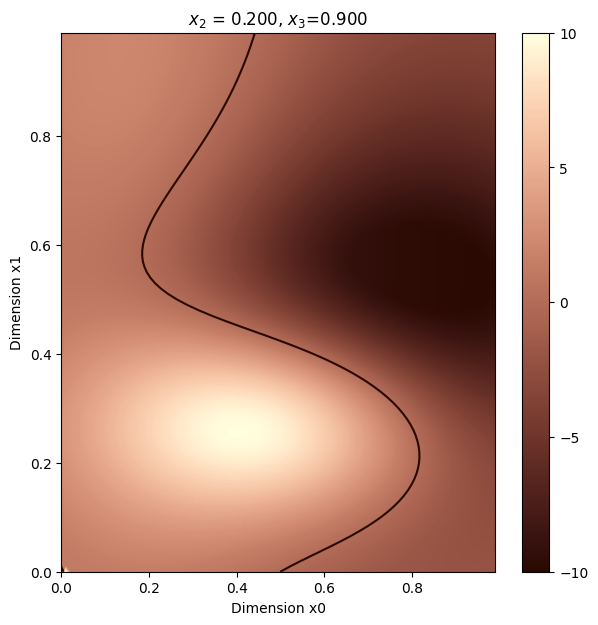

In [5]:
draw_2D_slice(model,0,1,0.2,0.9)

Similarly, we could look at how inputs 1 and 3 change the input when we set input 0 to 0.3 and input 2 to 0.2:

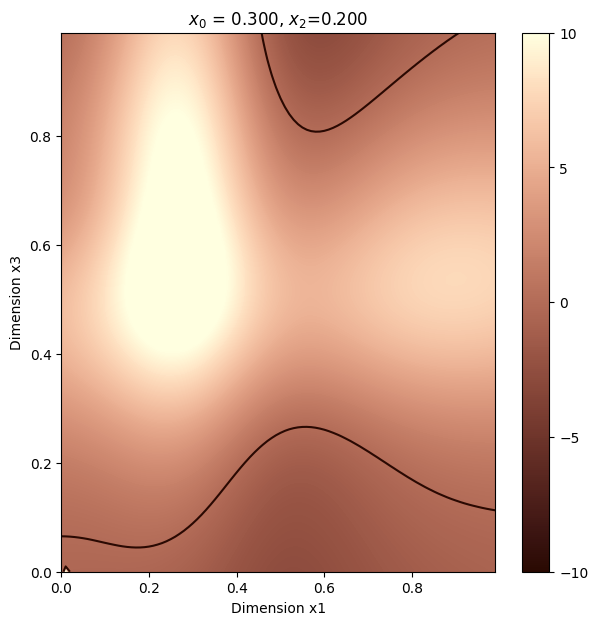

In [6]:
draw_2D_slice(model,1,3,0.3,0.2)

This tells us something -- it might be good for a reality check if we had some expectations about what effect each input would have, but it's still hard to ensure that the model does something sensible everywhere, especially for models where there are thousands of inputs.  Unfortunately, there are basically no good solutions to this problem at the time of writing.

However, let's view this from the perspective of a customer.  We can assume that the four inputs have some particular values, and see what the output is.

In [7]:
x = np.array([[0.3],[0.8],[0.6],[0.3]])
y = model.get_output(x)
print("Your credit score is %3.3f"%(y))
print("Sorry,  your loan is refused")

Your credit score is -3.288
Sorry,  your loan is refused


<ipython-input-7-0b674d8b935f>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Your credit score is %3.3f"%(y))


Well, that is bad news.  Why was our loan refused?  We'd like to understand what we could do to improve our credit score.   One way to do this is through individual conditional expectation or ICE plots ([Goldstein et al. 2015](https://arxiv.org/abs/1309.6392)). These take shows how the model output would change as we vary a single feature. Essentially, they answer the question: what if the $k^{th}$ feature had taken another value?

In [8]:
def ice_plot(model, x, k):
  # Get output for the input
  y = model.get_output(x)

  # Possible values of the k'th dimension of the input
  x_k_all = np.arange(0,1,0.001)
  # TODO write code that varies the k'th dimension of x and runs the model on the result to create a series of outputs y
  # Replace this line
  y = model.get_output(x)
  x_k_all = np.arange(0,1,0.001)
  # Create an array to store outputs
  y_all = np.zeros_like(x_k_all)
  # Iterate through all possible values of the k'th dimension
  for i, x_k in enumerate(x_k_all):
    # Create a copy of the original input
    x_modified = x.copy()
    # Modify the k'th dimension
    x_modified[k] = x_k
    # Run the model on the modified input and store the output
    y_all[i] = model.get_output(x_modified)

  return x_k_all, y_all.flatten()  # Flatten y_all to match x_k_all shape



  fig, ax = plt.subplots()
  ax.plot(x_k_all, np.squeeze(y_all), 'r-')
  ax.plot(x[k],y,'ro') ;
  ax.plot([0,1.0],[0.0,0.0],'k--')
  ax.set_xlabel('Dimension x%d'%(k))
  ax.set_ylabel('Credit score')
  ax.set_xlim(0,1)
  ax.set_ylim([-10,10])

  plt.show()



In [9]:
ice_plot(model, x, 0)
ice_plot(model, x, 1)
ice_plot(model, x, 2)
ice_plot(model, x, 3)

<ipython-input-8-f62506d1624d>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_all[i] = model.get_output(x_modified)


(array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
        0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
        0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
        0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
        0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
        0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
        0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
        0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
        0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
        0.117, 0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125,
      

We can learn something from this.  For example, decreasing the value of $x_{3}$ would be the most effective way to increase our credit score.  However, this might be impossible if it is a variable we can't control like our age.  Perhaps decreasing $x_0$ and $x_{1}$ might improve it further.  Well... perhaps, but we don't know what is going on in our model;  it might also make things much worse.

Local interpretable model-agnostic explanations or LIME ([Ribeiro et al. 2016](https://arxiv.org/abs/1602.04938)) approximate the main machine learning model locally around a given input using a simpler model that is easier to understand.  

The principle is simple.  First, we sample some points $\mathbf{x}_{i}$ close to  the input $\mathbf{x}$ that we are interested in.  Then we find the outputs $\mathbf{y}_i$ that correspond to those inputs.  Now we have a training set, and we can train any other kind of model that explains this small area of the input space. This can be a model that is much more interpretable and easier to understand such as a linear model or a tree.

In [10]:
# TODO -- Choose 100 points where each element of x is perturbed by noise sampled from a uniform distribution
# that takes values between [-0.05 and 0.05].  Then run these points through the model.
# Replace these lines
np.random.seed(42)  # I like 42
x_lime_train = np.matlib.repmat(x, 1, 100)
x_lime_train = x_lime_train + np.random.uniform(low=-0.05, high=0.05, size=x_lime_train.shape)
y_lime_train = model.get_output(x_lime_train)

# BEGIN_ANSWER
x_lime_train = x_lime_train + np.random.uniform(low=-0.05,high=0.05,size=x_lime_train.shape)
y_lime_train = model.get_output(x_lime_train)
# END_ANSWER

We'll train a linear model:

\begin{equation}
y = \beta_0 + \boldsymbol\phi^{T}\mathbf{x}
\end{equation}

In [11]:
from sklearn.linear_model import LinearRegression
# TODO -- train this model using a least squares loss
# to find values for the offset \beta_0 and the four slopes in \phi
# One way to do this is with sklearn.linear_model
# Replace this line

# Reshape the data for sklearn
X = x_lime_train.T  # sklearn expects (n_samples, n_features)
y = y_lime_train.T  # sklearn expects (n_samples,) or (n_samples, 1)
#create and train the linear model
model_lime = LinearRegression()
model_lime.fit(X, y)
phi = model_lime.coef_
beta = model_lime.intercept_

print("Intercept (β₀):", beta[0])
print("Coefficients (φ):", phi[0])

print(phi)

Intercept (β₀): -3.415682505430958
Coefficients (φ): [-22.39367641  13.51067129  -6.11764759  -0.80833329]
[[-22.39367641  13.51067129  -6.11764759  -0.80833329]]


This model is easily interpretable.  The k'th coefficient tells us the how much (and in which direction) changing the value of the k'th input will change the output.  This is only valid in the vicinity of the input $x$.

Note that a more sophisticated version of LIME would weight the training points according to how close they are to the original data point of interest.